In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.api import VAR, VECM
from scipy.stats import pearsonr
import numpy as np

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib agg
fig, ax = plt.subplots(figsize=(12,6))

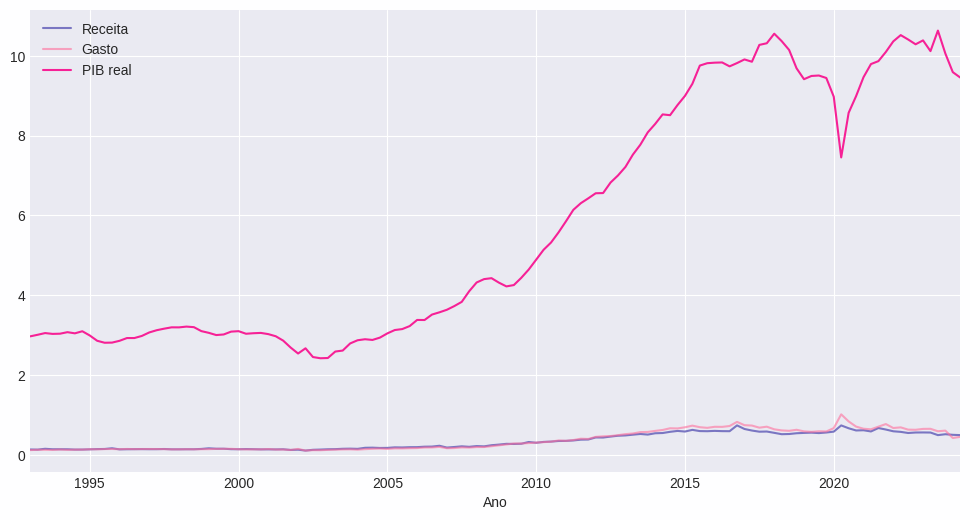

In [12]:
ax.clear()

df_raw = pd.read_parquet('../data/for_the_model_per_capita.parquet')

df_raw.plot(ax=ax)

ax.legend(['Receita', 'Gasto', 'PIB real'])

ax.set(
	xlabel='Ano'
)

fig

In [13]:
df_raw.corr()

,revenue_adj,expenditure_adj,gdp_real
revenue_adj,1.000000,0.991348,0.966071
expenditure_adj,0.991348,1.000000,0.954211
gdp_real,0.966071,0.954211,1.000000


## Normalize the data

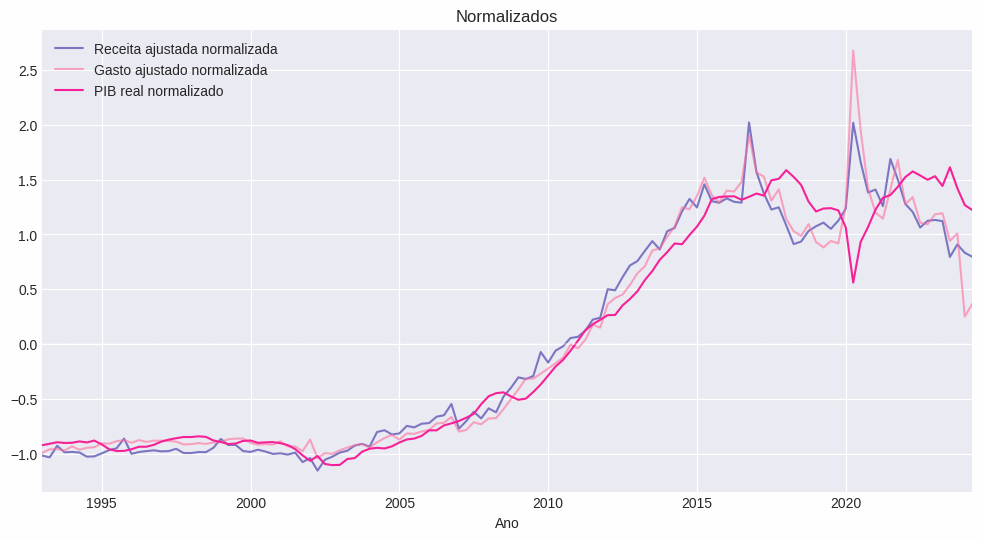

In [14]:
ax.clear()

df_norm = (df_raw - df_raw.mean()) / df_raw.std()

df_norm.plot(ax=ax)
ax.axhline(0, linestyle='--', color='w', alpha=0.3)

ax.legend(['Receita ajustada normalizada', 'Gasto ajustado normalizada', 'PIB real normalizado'])

ax.set(
	xlabel='Ano',
	title='Normalizados'
)

fig

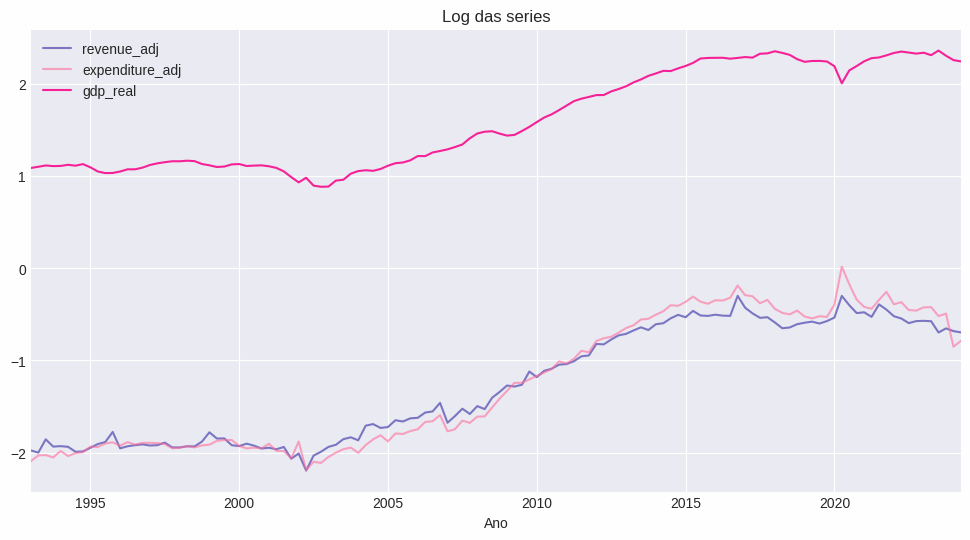

In [15]:
ax.clear()

df_log = np.log(df_raw)

df_log.plot(ax=ax)

ax.set(
	xlabel='Ano',
	title='Log das series'
)

fig

## Checking for non stationarity with ADF

In [16]:
def adfuller_test(df, signif=0.05):
	
	ret = pd.DataFrame(
		{
			'Column': [col for col in df.columns],
			f'Reject (signif. level {signif})': [adfuller(df[col])[1] < signif for col in df.columns]
		} 
	)
		
	return ret

In [17]:
adfuller_test(df_norm)

,Column,Reject (signif. level 0.05)
0,revenue_adj,False
1,expenditure_adj,False
2,gdp_real,False


#### Means we should remove the non-stationarity

## Removing the non-stationarity

In [18]:
def hpfilter_on_dataframe(df, lamb):
	cycles: dict = {}
	trends: dict = {}
	
	for col in df.columns:
		cycle, trend = hpfilter(df[col], lamb=lamb)
		
		cycles |= {
			col: cycle
		}
		
		trends |= {
			col: trend 
		}
		
	
	return pd.DataFrame(cycles), pd.DataFrame(trends)

In [19]:

method = 'hp_filter'

df_to_apply = df_log

match method:
	case 'diff':
		df_est = df_to_apply.diff().dropna()

	case 'pct_change':
		df_est = df_to_apply.pct_change().dropna()

	case 'log_diff':
		df_est = np.log(df_to_apply) - np.log(df_to_apply.shift())
		df_est = df_est.dropna()
		
	case 'hp_filter':
		df_est, trend = hpfilter_on_dataframe(df_to_apply, lamb=1600)

		trend = trend.add_suffix('_trend')

df_est = df_est.add_suffix('_des')

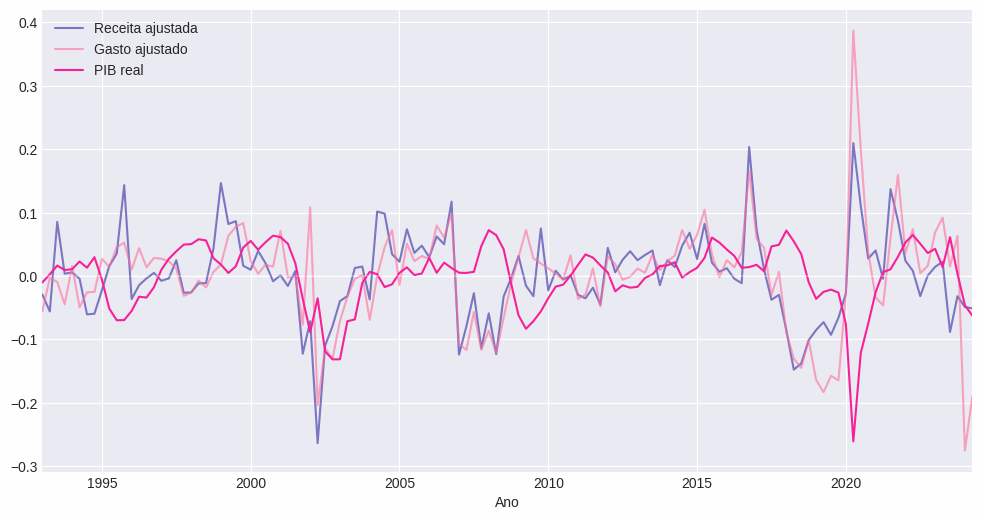

In [21]:
ax.clear()

# trend.plot(ax=ax)
df_est.plot(ax=ax)
ax.axhline(0, linestyle='--', color='w', alpha=0.3)

ax.legend(['Receita ajustada', 'Gasto ajustado', 'PIB real'])

ax.set(
	xlabel='Ano'
)

fig

In [11]:
ax.clear()

# df_2 = df_estdf_est.groupby(df_est.index.year).std()
df_2.plot(ax=ax)

ax.axhline(0, linestyle='--', color='w', alpha=0.3)

ax.legend(['Receita ajustada', 'Gasto ajustado', 'PIB real'])

ax.set(
	xlabel='Ano'
)

fig

NameError: name 'df_2' is not defined

In [22]:
adfuller_test(df_est)

,Column,Reject (signif. level 0.05)
0,revenue_adj_des,True
1,expenditure_adj_des,True
2,gdp_real_des,True


### Estimating the model

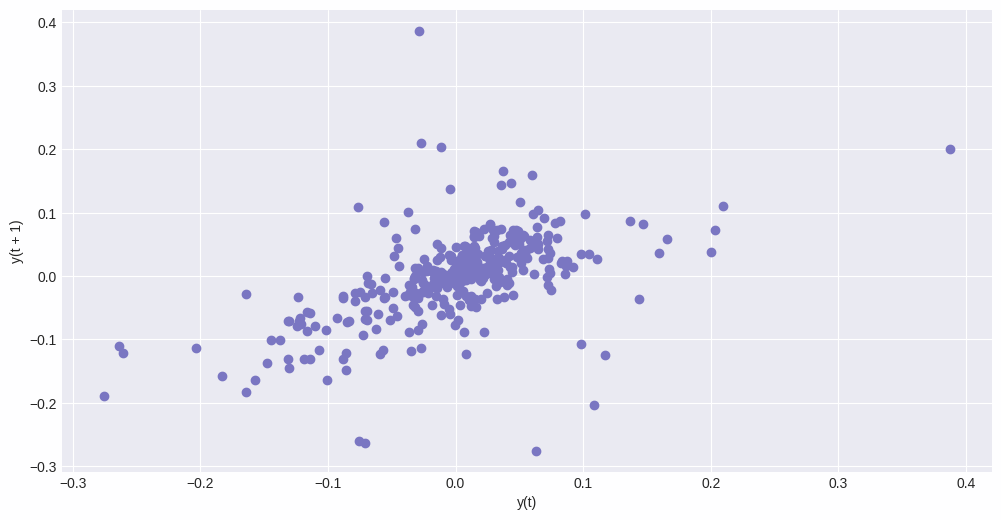

In [23]:
ax.clear()
pd.plotting.lag_plot(df_est, ax=ax)
fig

In [24]:
print('expenditure')

for lag in range(1, 24):
	first_series = df_est['gdp_real_des'].iloc[lag:]
	second_series = df_est['expenditure_adj_des'].iloc[:-lag]
	pearson_result = pearsonr(first_series, second_series)
	if pearson_result.pvalue < 0.05:
		print(f'Lag: {lag}')
		print(f'Corr: {pearson_result.statistic:.2f}\nP: {pearson_result.pvalue:.3f}')
		print('------')

print('revenue')

for lag in range(1, 24):
	first_series = df_est['gdp_real_des'].iloc[lag:]
	second_series = df_est['revenue_adj_des'].iloc[:-lag]
	pearson_result = pearsonr(first_series, second_series)
	if pearson_result.pvalue < 0.05:
		print(f'Lag: {lag}')
		print(f'Corr: {pearson_result.statistic:.2f}\nP: {pearson_result.pvalue:.3f}')
		print('------')


expenditure
Lag: 2
Corr: 0.23
P: 0.011
------
Lag: 3
Corr: 0.35
P: 0.000
------
Lag: 4
Corr: 0.38
P: 0.000
------
Lag: 5
Corr: 0.45
P: 0.000
------
Lag: 6
Corr: 0.41
P: 0.000
------
Lag: 7
Corr: 0.43
P: 0.000
------
Lag: 8
Corr: 0.33
P: 0.000
------
Lag: 9
Corr: 0.19
P: 0.044
------
Lag: 13
Corr: -0.19
P: 0.047
------
Lag: 14
Corr: -0.33
P: 0.000
------
Lag: 15
Corr: -0.36
P: 0.000
------
Lag: 16
Corr: -0.27
P: 0.005
------
revenue
Lag: 2
Corr: 0.29
P: 0.001
------
Lag: 3
Corr: 0.44
P: 0.000
------
Lag: 4
Corr: 0.44
P: 0.000
------
Lag: 5
Corr: 0.48
P: 0.000
------
Lag: 6
Corr: 0.46
P: 0.000
------
Lag: 7
Corr: 0.45
P: 0.000
------
Lag: 8
Corr: 0.38
P: 0.000
------
Lag: 9
Corr: 0.25
P: 0.007
------
Lag: 13
Corr: -0.22
P: 0.017
------
Lag: 14
Corr: -0.38
P: 0.000
------
Lag: 15
Corr: -0.36
P: 0.000
------
Lag: 16
Corr: -0.29
P: 0.002
------
Lag: 17
Corr: -0.20
P: 0.036
------


In [26]:
model = VAR(df_raw)

/home/carneiro/personal/insper/tcc/lab/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [27]:
lag_selection = model.select_order(maxlags=17)

In [28]:
lag_selection.summary()

,AIC,BIC,FPE,HQIC
0,-10.38,-10.31,3.106e-05,-10.35
1,-17.32,-17.02*,3.021e-08,-17.20
2,-17.40,-16.88,2.776e-08,-17.19
3,-17.41,-16.66,2.764e-08,-17.11
4,-17.33,-16.37,2.991e-08,-16.94
5,-17.29,-16.10,3.130e-08,-16.81
6,-17.66,-16.25,2.162e-08,-17.09
7,-17.75,-16.12,1.989e-08,-17.09
8,-17.71,-15.86,2.085e-08,-16.96
9,-17.79,-15.71,1.952e-08,-16.95


In [29]:
p = lag_selection.selected_orders['aic']  # 'bic', 'hq' or 'aic'

print(f'selected lag: {p}')

var_results = model.fit(p)
var_results.summary()

selected lag: 16


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 10, Nov, 2024
Time:                     18:32:09
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.5991
Nobs:                     110.000    HQIC:                  -17.7442
Log likelihood:           735.187    FPE:                5.56609e-09
AIC:                     -19.2079    Det(Omega_mle):     1.84305e-09
--------------------------------------------------------------------
Results for equation revenue_adj
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.065924         0.026585           -2.480           0.013
L1.revenue_adj              0.520053         0.240974            2.158           0.031
L1.expenditure_adj          0.

In [30]:
# Verificar a estabilidade
is_stable = var_results.is_stable()
print(f"O modelo é estável? {'Sim' if is_stable else 'Não'}")

O modelo é estável? Não


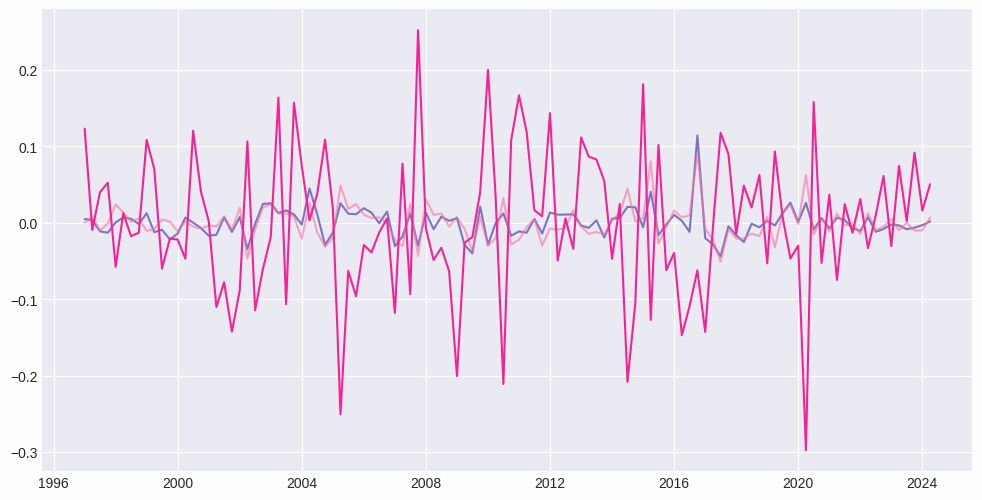

In [31]:
ax.clear()
# Resíduos do modelo
var_residuals = pd.DataFrame(var_results.resid)

# Plotar os resíduos
ax.plot(var_residuals)

fig

In [32]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Teste de Ljung-Box para autocorrelação
for col in var_residuals:
    lb_test = acorr_ljungbox(var_residuals[col], lags=[10], return_df=True)
    print(f'Resíduos de {col}')
    print(lb_test)
    print('\n')


Resíduos de revenue_adj
     lb_stat  lb_pvalue
10  3.202336   0.976253


Resíduos de expenditure_adj
      lb_stat  lb_pvalue
10  10.035317     0.4374


Resíduos de gdp_real
      lb_stat  lb_pvalue
10  10.116737   0.430312




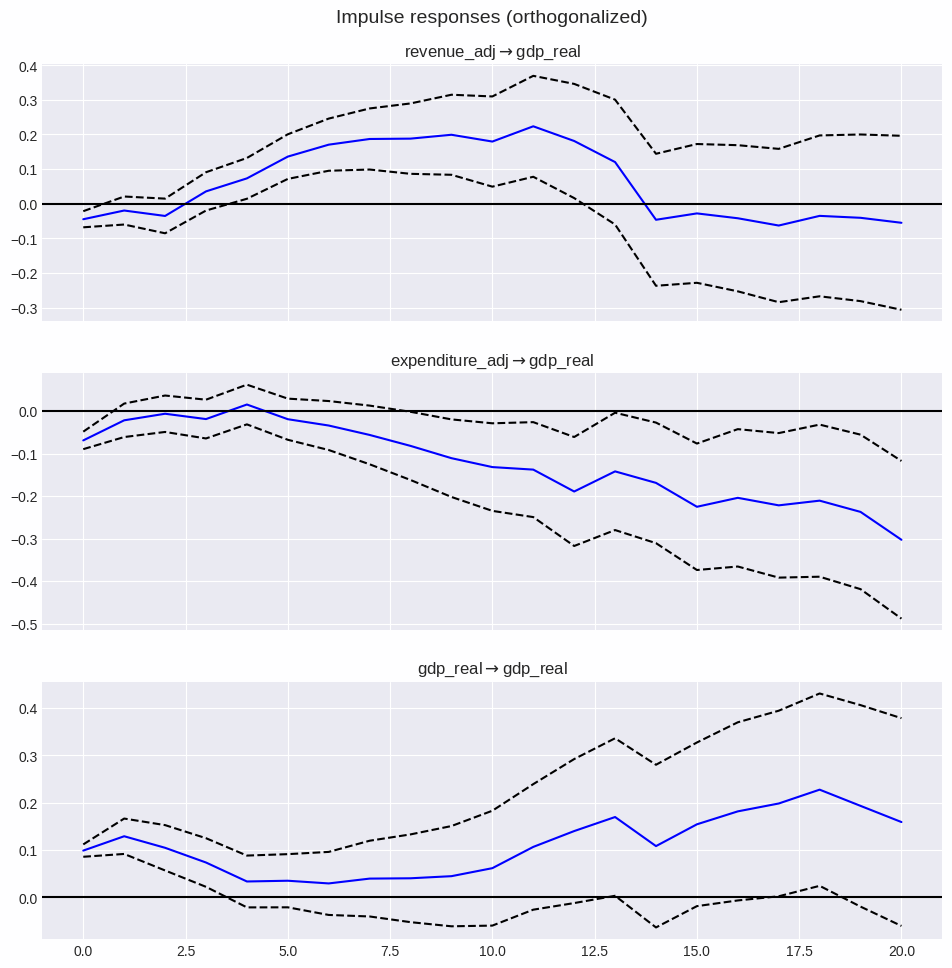

In [33]:
ax.clear()

irf = var_results.irf(periods=20)
irf.plot(
	orth=True,
	plot_stderr=True,
	response='gdp_real'
)